# Autoencoders and POD on slug flow (SF) dataset

Example notebook that displays the functionality of the built package for SF and reproduces the results from the report

In [1]:
# All of the necessary external package imports
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import random

# Built package imports
from ddganAE.utils import calc_pod
from ddganAE.models import AAE, AAE_combined_loss, CAE, SVDAE
from ddganAE.architectures.cae.D3 import *
from ddganAE.architectures.svdae import *
from ddganAE.architectures.discriminators import *

In [2]:
# Setting seeds for reproduceability
seed = 42
tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [3]:
filename = "./../submodules/DD-GAN/data/processed/sf_snapshots_800steps_notrand.npy"

## Proper Orthogonal Decomposition (POD)

First we try POD to benchmark the other models against

In [4]:
grids = np.load(filename)

In [10]:
# We do some preprocessing of the dataset

# Set all >0 to 0 and all <1 to 1 for volume fractions field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

# Rescale all the velocity fields
scaler = MinMaxScaler()
# Could also try subtracting the mean but this does not give better results in this case, normalization
# probably has similar effect
grids[:,:,:,:,:3] = grids[:,:,:,:,:3] # - np.mean(grids[:,:,:,:,:3]) # Subtracting out the mean
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

In [11]:
# Reshaping for POD
grids_reshaped = grids.reshape((int(grids.shape[0]/10), 10, grids.shape[1], grids.shape[2], grids.shape[3], grids.shape[4]))
grids_long = np.moveaxis(grids_reshaped, 1, 5).reshape((grids_reshaped.shape[0], -1, grids_reshaped.shape[1]))
grids_long = np.swapaxes(grids_long, 0, 2)

In [12]:
# Calculate POD
coeffs, R, s = calc_pod(grids_long, nPOD=10)

SSmatrix (8000, 8000)


In [14]:
# Calculate MSE
mean = 0
recon_grid = np.zeros(grids_long.shape)
for j in range(10):
    recon = R @ coeffs[j]
    for i in range(800):
        mean += tf.keras.losses.MSE(recon[:, i], grids_long[j, :, i]).numpy()/8000
    recon_grid[j, :, :] = recon
print("POD MSE loss of the normalized dataset's reconstruction: ", mean)

0.0021950925407295437


In [15]:
# Invert the earlier reshaping and scaling
grids_recon = np.moveaxis(recon_grid, 2, 0).reshape(*grids.shape)
grids_recon[:,:,:,:,:3] = scaler.inverse_transform(grids_recon[:,:,:,:,:3].reshape(-1, 1)).reshape(grids_recon[:,:,:,:,:3].shape)
#grids_recon[:,:,:,:,:3] += np.mean(grids[:,:,:,:,:3]) # Putting the mean back in, if we subtract it first

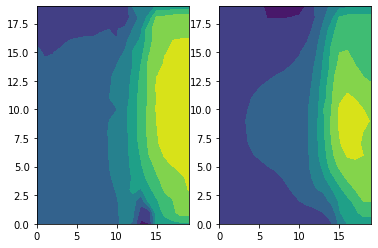

In [17]:
# Let's plot a reconstruction to see if it visually corresponds to what we expect
grid = grids[2000, 10, :, :, 0]
grid_recon = grids_recon[2000, 10, :, :, 0]
fig, ax = plt.subplots(1,2)
ax[0].contourf(grid)
ax[1].contourf(grid_recon)

In [ ]:
# reshape to (ngrids, nscalar, nx, ny, nz, ntime)
# np.save("pod_10vars_prediction_sf.npy", grids_recon[:, :, :, :, :])

# Convolutional Autoencoder

In [2]:
# This cell does preprocessing
grids = np.load(filename)

# Set all >0 to 0 and all <1 to 1 for alpha field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

# Rescale all the velocity fields
scaler = MinMaxScaler()
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

x_train, x_val = train_test_split(grids, test_size=0.1)

In [7]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.98, beta_2=0.9)

input_shape = (60, 20, 20, 4)

encoder, decoder = build_wide_omata_encoder_decoder(input_shape, 10, initializer, info=True, act='relu', dense_act='relu', final_act="sigmoid")

cae = CAE(encoder, decoder, optimizer)
cae.compile(input_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 60, 20, 20, 32)    16032     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 30, 10, 10, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 30, 10, 10, 64)    55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 5, 5, 64)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 5, 5, 64)      110656    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 8, 3, 3, 64)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 8, 3, 3, 128)      2

In [8]:
cae.train(grids, 100, val_data=grids, batch_size=64)

In [10]:
grids_recon = cae.predict(grids)

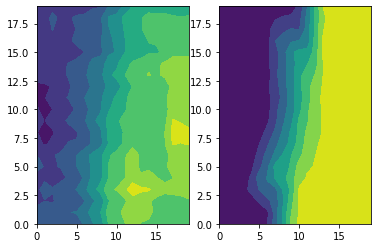

In [15]:
# Let's plot a reconstruction to see if it visually corresponds to what we expect
grid = grids[2000, 10, :, :, 0]
grid_recon = grids_recon[2000, 10, :, :, 0]
fig, ax = plt.subplots(1,2)
ax[0].contourf(grid)
ax[1].contourf(grid_recon)

In [ ]:
# reshape to (ngrids, nscalar, nx, ny, nz, ntime)
np.save("cae_prediction_sf.npy", out_grids)

# Adversarial Autoencoder

### Preprocessing

In [2]:
# This cell does preprocessing
grids = np.load(filename)

# Set all >0 to 0 and all <1 to 1 for alpha field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

# Rescale all the velocity fields
scaler = MinMaxScaler()
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

x_train, x_val = train_test_split(grids, test_size=0.1)

In [6]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.00005, beta_1=0.9, beta_2=0.999)

input_shape = (60, 20, 20, 4)

encoder, decoder = build_deeper_omata_encoder_decoder(input_shape, 10, initializer, info=True, act='elu', dense_act='relu')
discriminator = build_custom_discriminator(10, initializer, info=True)

aae = AAE_combined_loss(encoder, decoder, discriminator, optimizer)
aae.compile(input_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 60, 20, 20, 32)    16032     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 30, 10, 10, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 30, 10, 10, 64)    55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 5, 5, 64)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 5, 5, 64)      110656    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 8, 3, 3, 64)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 8, 3, 3, 128)      2

In [7]:
aae.train(x_train, 50, val_data=x_val, batch_size=2, val_batch_size=2)

KeyboardInterrupt: 

# SVD Autoencoder

In [18]:
# This cell does the preprocessing
grids = np.load(filename)
# Set all >0 to 0 and all <1 to 1 for alpha field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

# Rescale all the velocity fields
scaler = MinMaxScaler()
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

x_train, x_val = train_test_split(grids, test_size=0.1 )

In [19]:
# Some reshaping for the SVD AE
x_train_long = np.moveaxis(np.moveaxis(x_train, 4, 0), 1, 4).reshape((x_train.shape[-1], x_train.shape[1]*x_train.shape[2]*x_train.shape[3], x_train.shape[0]))
x_val_long = np.moveaxis(np.moveaxis(x_val, 4, 0), 1, 4).reshape((x_val.shape[-1], x_val.shape[1]*x_val.shape[2]*x_val.shape[3], x_val.shape[0]))

In [2]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.0005, beta_1=0.98, beta_2=0.99999)

encoder, decoder = build_vinicius_encoder_decoder(30, 10, initializer, act='elu', dense_act='relu', info=True, reg=0, dropout=0.55, batchnorm=False)

svdae = SVDAE(encoder, decoder, optimizer)
svdae.compile(30, weight_loss=False)

# Only set this when loading in the model
# svdae.R = np.load("R_svdae.npy")

NameError: name 'tf' is not defined

In [8]:
svdae.train(x_train_long, 100, val_data=x_val_long, batch_size=2, val_batch_size=2)

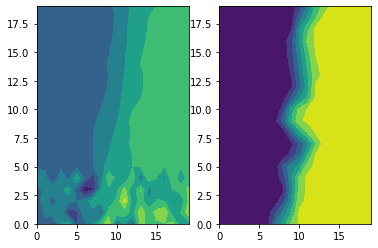

In [16]:
original = x_train_long[0, :, 15]

result = svdae.predict_single(original)
result = result.reshape((1, 60, 20, 20, 1))

original = original.reshape((1, 60, 20, 20, 1))

fig, ax = plt.subplots(1,2)
ax[0].contourf(result[0][0, :, :, 0])
ax[1].contourf(original[0][0, :, :, 0])